In [5]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [8]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [9]:
tokenizer = RegexpTokenizer(r'w+')
words = tokenizer.tokenize(text)

In [10]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [12]:
# Feature Engineering

WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['w', 'w', 'w', 'w', 'w']
www


In [13]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [14]:
print(X[0][0])

[ True False]


In [15]:
#Building Recurrent Neural Network

model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [17]:
# Training the Next Word Prediction Model

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
86/86 [==============================] - 4s 25ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.2585 - val_accuracy: 0.9844
Epoch 2/20
86/86 [==============================] - 2s 18ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.2420 - val_accuracy: 0.9844
Epoch 3/20
86/86 [==============================] - 2s 19ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.2050 - val_accuracy: 0.9844
Epoch 4/20
86/86 [==============================] - 2s 19ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.2084 - val_accuracy: 0.9844
Epoch 5/20
86/86 [==============================] - 3s 33ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.2044 - val_accuracy: 0.9844
Epoch 6/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.1741 - val_accuracy: 0.9844
Epoch 7/20
86/86 [==============================] - 2s 19ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.2475 - val_accuracy: 0.9844
Epoch 8/20
86

In [19]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

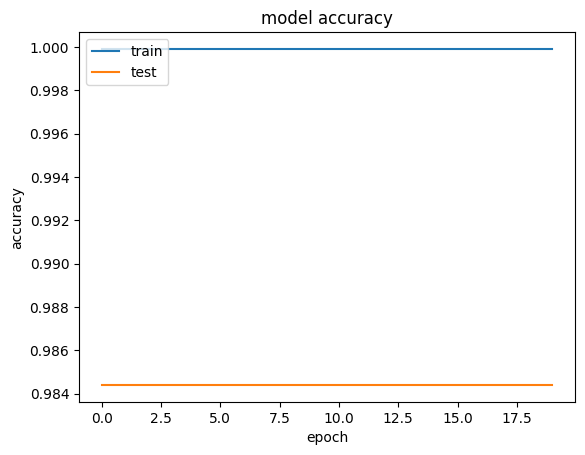

In [21]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

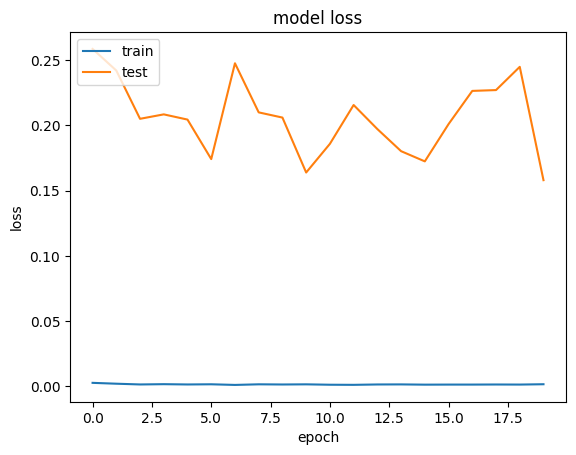

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [40]:
# Testing Next Word Prediction Model

def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        if word in unique_word_index:
            x[0, t, unique_word_index[word]] = 1
    return x

In [41]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [42]:
def predict_completion(text, indices_char):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [43]:
def predict_completions(text, n=3, indices_char=None):
    if indices_char is None:
        raise ValueError("indices_char dictionary is not provided.")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx], indices_char) for idx in next_indices]

In [44]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [46]:
indices_char = {i: chr(ord('a') + i) for i in range(27)}

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5, indices_char))
    print()